In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D

TRAIN_DIR = 'train'
VALIDATE_DIR = 'validate'
TEST_DIR = 'test'
AUGMENTED_DIR = 'augmented'

image_width = 128
image_height = 128
pool_size = 2
learning_rate = 1e-3 # 0.0004
batch_size = 32
epochs=5

classes = {'dog': 1, 'cat': 0}

Using TensorFlow backend.


In [4]:
def read_image(dir_path, file_name):
    image_path = os.path.join(dir_path, file_name)
    raw_image = load_img(image_path, target_size=(image_width, image_height))
    if raw_image is not None:
        img_array = img_to_array(raw_image)
        return img_array


In [7]:
def display_image(image, label=None):
    label_name = label
    if label == classes['dog']:
        label_name = 'Dog'
    elif label == classes['cat']:
        label_name = 'Cat'
    
    plt.title("label: %s, name: %s" % (label, label_name))
    plt.imshow(array_to_img(image))
    plt.show()


In [5]:
# def load_train_data(is_evaluation=False):
#     features = []
#     labels = []
#     file_list = os.listdir(TRAIN_DIR)[:150]
#     bucket_size = int(len(file_list)*0.9)

#     if is_evaluation:
#         file_list = file_list[bucket_size:]
#     else:
#         file_list = file_list[:bucket_size]
    
#     shuffle(file_list)
#     for file_name in tqdm(file_list):
#         # 1 = dog, 0 = cat
#         label = classes[file_name.split('.')[0]]
#         image = read_image(TRAIN_DIR, file_name)
#         if image is not None and label is not None:
#             features.append(image)
#             labels.append(label)
#     return np.array(features), labels

def load_test_data():
    test_data = []
    file_list = os.listdir(TEST_DIR)[:50]
    shuffle(file_list)
    for file_name in tqdm(file_list):
        image = read_image(TEST_DIR, file_name)
        if image is not None:
            test_data.append(image)
    return np.array(test_data)


In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # brightness_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255)

source_datagen = ImageDataGenerator(rescale=1./255)

for label in classes:
    for dir_type in [TRAIN_DIR, VALIDATE_DIR]:
        target_dir = os.path.join(AUGMENTED_DIR, dir_type, label)
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

train_file_list = os.listdir(TRAIN_DIR)[:200]
bucket_size = int(len(train_file_list)*0.8)

for file_name in tqdm(train_file_list[:bucket_size]):
    file_name_array = file_name.split('.')
    image = load_img(os.path.join(TRAIN_DIR, file_name))
    image = img_to_array(image)
    image = image.reshape((1,) + image.shape)
    if image is not None:
        target_dir = os.path.join(AUGMENTED_DIR, TRAIN_DIR, file_name_array[0])
    
        for _ in source_datagen.flow(image, batch_size=1, save_to_dir=target_dir, save_prefix=file_name_array[1], save_format='jpeg'):
            break
        
#         count = 0
#         for _ in datagen.flow(image, batch_size=1, save_to_dir=target_dir, save_prefix=file_name_array[1], save_format='jpeg'):
#             count += 1
#             if count > 100:
#                 break

for file_name in tqdm(train_file_list[bucket_size:]):
    file_name_array = file_name.split('.')
    image = load_img(os.path.join(TRAIN_DIR, file_name))
    image = img_to_array(image)
    image = image.reshape((1,) + image.shape)
    if image is not None:
        target_dir = os.path.join(AUGMENTED_DIR, VALIDATE_DIR, file_name_array[0])
        
        for _ in source_datagen.flow(image, batch_size=1, save_to_dir=target_dir, save_prefix=file_name_array[1], save_format='jpeg'):
            break
            
#         count = 0
#         for _ in datagen.flow(image, batch_size=1, save_to_dir=target_dir, save_prefix=file_name_array[1], save_format='jpeg'):
#             count += 1
#             if count > 50:
#                 break
                


100%|██████████| 40/40 [00:00<00:00, 111.65it/s]


In [8]:
# X_train, y_train = load_train_data()

In [9]:
# for i in range(5):
#     display_image(X_train[i], y_train[i])

In [10]:
# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     # brightness_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     fill_mode='nearest',
#     horizontal_flip=True,
#     rescale=1.0/255,
#     validation_split=0.2)

# datagen.fit(X_train)


In [11]:
# train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
# validation_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')

# history = model.fit_generator(
#     train_generator,
#     validation_data=validation_generator,
#     steps_per_epoch=train_generator.n/batch_size,
#     validation_steps=validation_generator.n/batch_size,
#     epochs=epochs,
#     verbose=1)

In [12]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(AUGMENTED_DIR, TRAIN_DIR),
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3226 images belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(AUGMENTED_DIR, VALIDATE_DIR),
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary')

Found 40 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (5,5), input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.n/batch_size,
    validation_steps=validation_generator.n/batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
101/100 [==============================] - 42s 420ms/step - loss: 7.9104 - acc: 0.5038 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/5
101/100 [==============================] - 40s 394ms/step - loss: 7.9104 - acc: 0.5038 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/5
101/100 [==============================] - 40s 400ms/step - loss: 7.9037 - acc: 0.5042 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/5
101/100 [==============================] - 40s 396ms/step - loss: 7.9059 - acc: 0.5041 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/5
101/100 [==============================] - 39s 389ms/step - loss: 7.9037 - acc: 0.5042 - val_loss: 7.9712 - val_acc: 0.5000


In [15]:
model.save('model.h5')
model.save_weights('weights.h5')

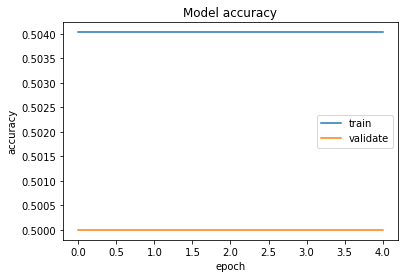

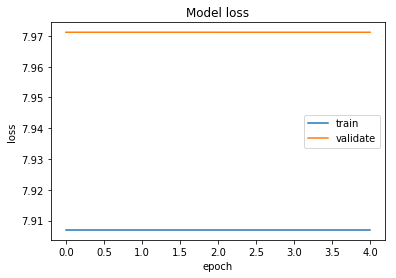

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

In [17]:
# X_evaluate, y_evaluate = load_train_data(True)
# evaluate_generator = ImageDataGenerator(rescale=1./255).flow(X_evaluate, y_evaluate, batch_size=batch_size)

# evaluation = model.evaluate_generator(evaluate_generator, steps=evaluate_generator.n)
# evaluation

In [18]:
X_test = load_test_data()
test_generator = ImageDataGenerator(rescale=1./255).flow(X_test, batch_size=batch_size)

predictions = model.predict_generator(test_generator, steps=test_generator.n)

100%|██████████| 50/50 [00:00<00:00, 401.04it/s]


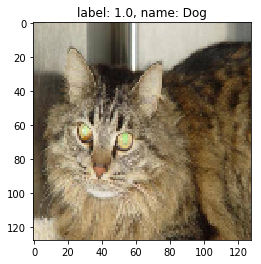

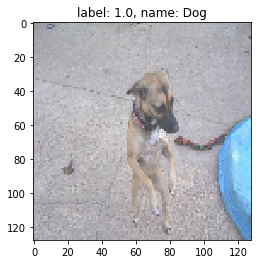

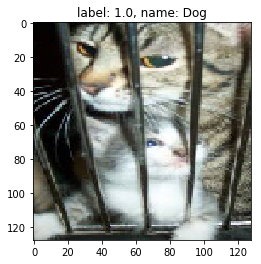

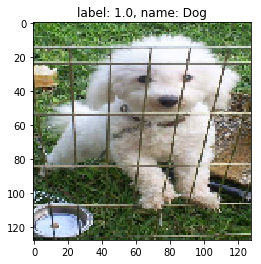

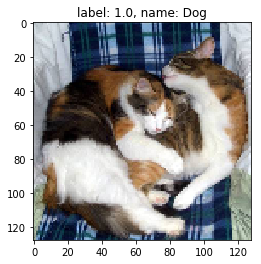

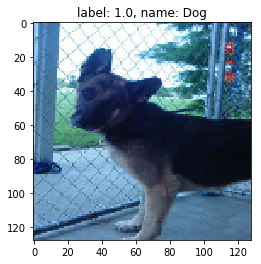

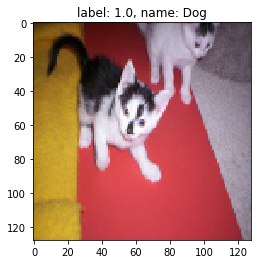

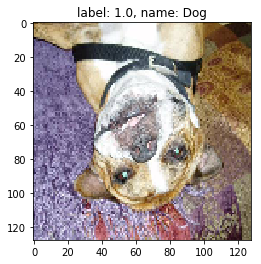

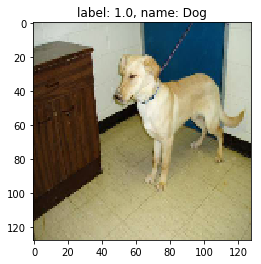

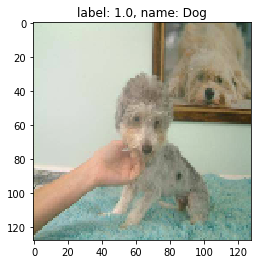

In [19]:
for i in range(len(predictions[:10])):
    display_image(X_test[i], predictions[i][0])
